In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import image
from PIL import Image

# Model variables

In [3]:
epochs = 5
shape = (64, 64, 3)

## Prepare data

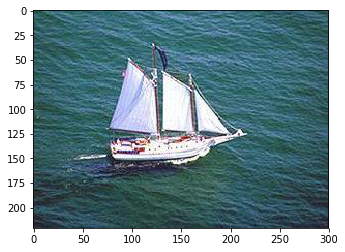

In [4]:
with open('101_ObjectCategories/files_list.txt') as f:
    not_face_list = f.readlines()
    
with open('Faces/files_list.txt') as f:
    face_files_list = f.readlines()
    
not_faces = [i.strip() for i in not_face_list] 
face_list = [i.strip() for i in face_files_list] 

def readRandomNonFace():
    index = int(np.random.random(1)*len(not_face_list))
    x = plt.imread(not_faces[index])
    while(len(x.shape) != 3):
        index = int(np.random.random(1)*len(not_face_list))
        x = plt.imread(not_faces[index])    
    return x

# test
plt.imshow(readRandomNonFace())

In [5]:
faces = [scipy.misc.imresize(plt.imread(i), shape) for i in face_list]
print('Faces read')
nonFaces = [scipy.misc.imresize(readRandomNonFace(), shape) for i in range(len(faces)*2)]

Faces read


In [6]:
X = np.concatenate(faces + nonFaces).reshape((len(faces)+len(nonFaces), shape[0], shape[1], shape[2])).astype(np.float32)
y = [[1] for i in range(len(faces))]
y.extend([[0] for i in range(len(nonFaces))])
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

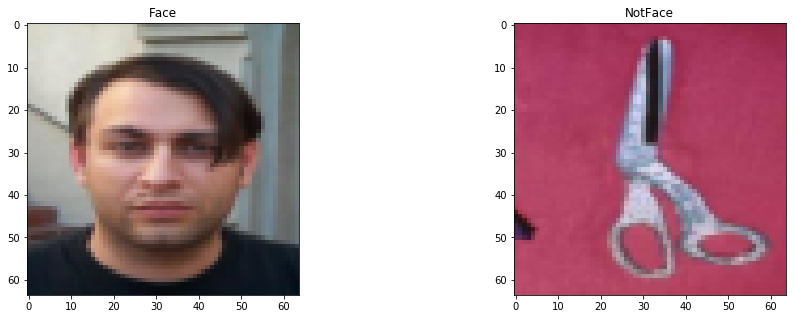

In [7]:
x1 = faces[int(np.random.random(1)*len(faces))]
x2 = nonFaces[int(np.random.random(1)*len(nonFaces))]

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(x1)
plt.title('Face');

plt.subplot(122)
plt.imshow(x2)
plt.title('NotFace');

# Craft and fit model

In [8]:
def split(features, labels, batch_size):
    for i in range(0, len(features), batch_size):
        yield (features[i:i+batch_size], labels[i:i+batch_size])

In [9]:
tf.reset_default_graph()

with tf.variable_scope("placeholders"):
    features = tf.placeholder(tf.float32, shape=[None, shape[0], shape[1], shape[2]])
    labels = tf.placeholder(tf.int32, shape=[None, 1])
    
# ARCHITECTURE
with tf.variable_scope("convolutional"):
    input_layer = tf.reshape(features, [-1, shape[0], shape[1], shape[2]])

    conv1 = tf.layers.conv2d(
                inputs=input_layer,
                filters=32,
                kernel_size=3,
                padding='same',
                activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2)

    conv2 = tf.layers.conv2d(
                inputs=pool1,
                filters=32,
                kernel_size=3,
                padding='same',
                activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2)

    conv3 = tf.layers.conv2d(
                inputs=pool2,
                filters=64,
                kernel_size=3,
                padding='same',
                activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=2, strides=2)   
    flatten = tf.reshape(pool3, [-1, int((shape[0]/8)*(shape[1]/8)*64)])  

with tf.variable_scope("dense"):
    dense1 = tf.layers.dense(
                inputs=flatten,
                units=512)
    dense1_batch = tf.layers.batch_normalization(dense1, training=True)
    dense1_relu = tf.nn.relu(dense1_batch)

#     dense2 = tf.layers.dense(
#                 inputs=dense1_relu,
#                 units=256,
#                 activation=tf.nn.relu)

    dense3 = tf.layers.dense(
                inputs=dense1_relu,
                units=128)
    dense3_batch = tf.layers.batch_normalization(dense3, training=True)
    dense3_relu = tf.nn.relu(dense3_batch)

    dense4 = tf.layers.dense(
                inputs=dense3_relu,
                units=64,
                activation=tf.nn.relu)

with tf.variable_scope("logits"):
    logits = tf.layers.dense(inputs=dense4, units=2)

with tf.variable_scope("output"):
    ar_max = tf.argmax(input=logits, axis=1)
    predictions = {
        'classes': ar_max,
        'probabilities': tf.nn.softmax(logits)
    }

# EVALUATION output point
accuracy = tf.metrics.accuracy(labels=labels, predictions=ar_max)
# confusion = tf.confusion_matrix(labels[:, 1], ar_max)

# TRAINING output point
loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
train_op = tf.train.AdamOptimizer().minimize(loss=loss, global_step=tf.train.get_global_step())

In [10]:
# sess.close()

sess = tf.Session()
init = [tf.global_variables_initializer(), tf.local_variables_initializer()]
sess.run(init)

acc_test = sess.run(accuracy[1], feed_dict={features: X_test, labels: y_test})
opt, acc_train = sess.run((loss, accuracy[1]), feed_dict={features: X_train, labels: y_train})
print('Loss: %.5f, Training acc: %d%%, Test acc: %d%%' % (opt, acc_train*100, acc_test*100))

for step in range(7):
    for batch in split(X_train, y_train, 64):
        feed_dict = { features: batch[0], labels: batch[1]}
        sess.run(train_op, feed_dict=feed_dict)

    acc_test = sess.run(accuracy[1], feed_dict={features: X_test, labels: y_test})
    opt, acc_train = sess.run((loss, accuracy[1]), feed_dict={features: X_train, labels: y_train})
    print('Loss: %.5f, Training acc: %d%%, Test acc: %d%%' % (opt, acc_train*100, acc_test*100))

Loss: 1.01564, Training acc: 38%, Test acc: 40%
Loss: 0.02803, Training acc: 68%, Test acc: 48%
Loss: 0.01025, Training acc: 79%, Test acc: 71%
Loss: 0.00342, Training acc: 84%, Test acc: 80%
Loss: 0.00181, Training acc: 87%, Test acc: 85%
Loss: 0.00126, Training acc: 89%, Test acc: 87%
Loss: 0.00088, Training acc: 90%, Test acc: 89%
Loss: 0.00072, Training acc: 92%, Test acc: 91%


In [11]:
predictions = sess.run(ar_max, feed_dict={features: X, labels: y})

conf = confusion_matrix(y, predictions)
print(conf)

[[869   1]
 [  1 434]]


# Wrongly classified examples

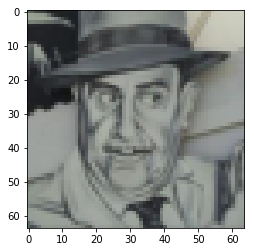

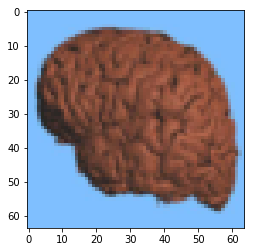

In [12]:
for i, j, k in zip(predictions, y, X):
    if i != j:
        k = k.astype(np.uint8)
        plt.figure()
        plt.imshow(k)

# Face location

In [13]:
def split_pic_into_frames(image, size=64, stride=1/2):
    data = []
    sh_x = image.shape[0]
    sh_y = image.shape[1]
    len_x = size
    len_y = size
    stride_x = np.ceil(len_x*stride).astype(int)
    stride_y = np.ceil(len_y*stride).astype(int)
    
    for y in range(0, sh_y, stride_y):
        for x in range(0, sh_x, stride_x):
            patch = image[y:y+len_y, x:x+len_x]
            if patch.shape[0]*patch.shape[1]!=0:
#                 plt.imsave('FaceParts/%s_%ix%i.jpg' % (name, y, x), patch)
                data.append([patch, (x, y), (x+len_x, y+len_y)])
    return data

In [17]:
# for i in ['image_0121', 'image_0133', 'image_0100', 'image_0145', 'image_0144', 'image_0187', 'image_0166', 'image_0132']:
img = plt.imread('Faces/image_0133.jpg')
img = scipy.misc.imresize(img, (img.shape[1], img.shape[1], img.shape[1]))
img_orig = img.copy()
patches = split_pic_into_frames(img, stride=1/8)
a = [scipy.misc.imresize(i[0], shape) for i in patches]

preds = sess.run(tf.nn.softmax(logits), feed_dict={features: a, labels: y[:len(a)]})

In [18]:
coord_start = np.array(patches)[:, 1]
coord_end = np.array(patches)[:, 2]

img.setflags(write=1)

for start, end, pred in zip(coord_start, coord_end, preds):
    R = img_orig[start[0]:end[0], start[1]:end[1]][:, :, 0]
    G = img_orig[start[0]:end[0], start[1]:end[1]][:, :, 1]
    B = img_orig[start[0]:end[0], start[1]:end[1]][:, :, 2]
    img[start[0]:end[0], start[1]:end[1]][:, :, 0] = np.array(R*pred[1]).astype(np.uint8)
    img[start[0]:end[0], start[1]:end[1]][:, :, 1] = np.array(G*pred[1]).astype(np.uint8)
    img[start[0]:end[0], start[1]:end[1]][:, :, 2] = np.array(B*pred[1]).astype(np.uint8)

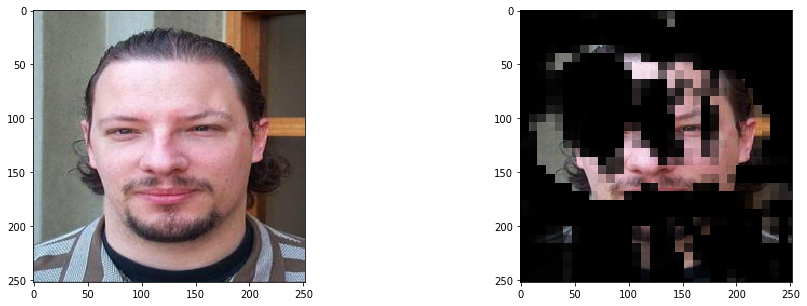

In [20]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(img_orig)
plt.subplot(122)
plt.imshow(img)

In [11]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [12]:
frozen_graph = freeze_session(keras.backend.get_session(), output_names=[model.output.op.name])

INFO:tensorflow:Froze 97 variables.
Converted 97 variables to const ops.


In [13]:
tf.train.write_graph(frozen_graph, "frozen_model", "model.pb", as_text=False)

'frozen_model/model.pb'

checkpoint = tf.train.get_checkpoint_state('./frozen/')
input_checkpoint = checkpoint.model_checkpoint_path

absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
output_graph = absolute_model_dir + "/frozen_model.pb"

clear_devices = True

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    saver.restore(sess, input_checkpoint)

    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess,
        tf.get_default_graph().as_graph_def(),
        ['activation_7/Softmax']
    ) 

    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(output_graph_def.SerializeToString())
    print("%d ops in the final graph." % len(output_graph_def.node))